# Neural Network from Scratch

Following [Welch Labs' series](https://www.youtube.com/watch?v=bxe2T-V8XRs)  with some modifications

## Notes

### Forward Pass
 - $z_2 = X W_1 $
 - $a_2 = f(z_2)$
 - $z_3 = a_2 W_2$
 - $\hat{y} = f(z_3)$

where $f(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function but generally can be any activation function

## Backpropogation / Gradient Descent
 - $ J = \frac{1}{2} \sum (y-\hat{y})^2$ - quadratic cost function

 We calculate $\partial J/ \partial W_1$ and $ \partial J/\partial W_2$

 $$\begin{align*}
\partial J/\partial W_2 &= \frac{1}{2} \sum_i \frac{{\partial}}{\partial W_2} (y - \hat{y}^2) \\
&= - \sum_i (y - \hat{y}) \frac{\partial \hat{y}}{\partial W_2} \\
&= - \sum_i\;\; (y - \hat{y}) \;\; \underbrace{\frac{\partial \hat{y}}{\partial z_3}}_{=f'(z_3)} \;\;\underbrace{ \frac{\partial z_3}{\partial W_2} }_{z_3 = a_2 W_2}
\\ && \text{derivation missing...}
\\&= a_2^T \underbrace{ \left( -(y-\hat{y}) \odot f'(z_3) \right) }_{\delta_3}
 \end{align*}$$

 and similarly:
 $$\begin{align*}
 \partial J/\partial W_1 &= \frac{1}{2} \sum_i \frac{{\partial}}{\partial W_1} (y - \hat{y}^2) \\
 &= - \sum_i (y - \hat{y}) \frac{\partial \hat{y}}{\partial W_1} \\
&= - \sum_i\;\; (y - \hat{y}) \;\; \underbrace{\frac{\partial \hat{y}}{\partial z_3}}_{=f'(z_3)} \frac{\partial z_3}{\partial W_1}   \end{align*}$$

We have:
$$\begin{align*}
\frac{\partial z_3}{\partial W_1} = \underbrace{ \frac{\partial z_3}{\partial a_2}}_{z_3 = a_2 W_2} \;\; \underbrace{ \frac{\partial a_2}{\partial z_2}}_{f'(z_2)} \;\; \underbrace{ \frac{\partial z_2}{\partial w_1}}_{z_2 = X W_1}
\end{align*}$$

Altogether, we have (from the Python code)

$$ \frac{\partial J}{\partial W} = X^T \underbrace{ \delta^3 W_2^T f'(z_2) }_{\delta_2} $$

In what follows, we assume that $y$ only consists of $\{0,1\}$ (i.e. we are training the network to do a binary classification task)

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import sample
from math import inf
from typing import Optional

np.random.seed(0)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1- sigmoid(z))

class NeuralNetwork:
    def __init__(self, s1, s2, s3, W1=None, W2=None):
        self.s1 = s1
        self.s2 = s2
        self.s3 = s3
        self.W1 = W1 if W1 is not None else np.random.randn(s1, s2)
        self.W2 = W2 if W2 is not None else np.random.randn(s2, s3)

    def forward(self, X):
        z2 = np.dot(X, self.W1)
        a2 = sigmoid(z2)
        z3 = np.dot(a2, self.W2)
        return sigmoid(z3)

    def cost_function(self, X, y):
        y_hat = self.forward(X)
        return 0.5 * np.sum((y - y_hat)**2)

    def get_accuracy(self, X, y):
        y_hat = self.forward(X) > 0.5
        return sum(y == y_hat) / len(y)

    def cost_function_prime(self, X, y):
        z2 = X @ self.W1
        a2 = sigmoid(z2)
        z3 = a2 @ self.W2
        y_hat = sigmoid(z3)
        δ3 = -(y - y_hat) * sigmoid_prime(z3)
        dJdW2 = a2.T @ δ3
        δ2 = (δ3 @ self.W2.T) * sigmoid_prime(z2)
        dJdW1 = X.T @ δ2
        return (dJdW1, dJdW2)

100%|██████████| 100000/100000 [00:19<00:00, 5185.15it/s]


[[0.01066416]
 [0.97116477]
 [0.97116471]
 [0.03871334]]


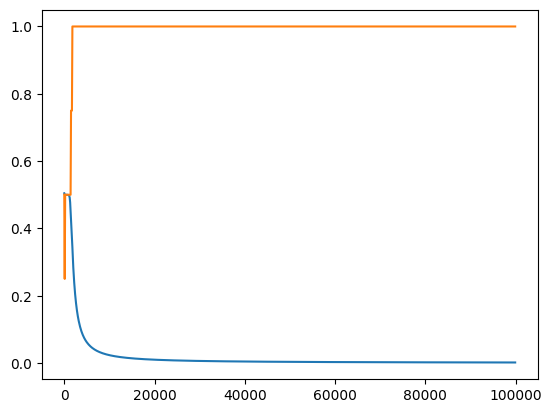

In [ ]:
# Cheat and start at local minimum
NN = NeuralNetwork(
    2,2,1,
    W1 = np.array([[1., 0.], [0., 1.]]),
    W2 = np.array([[0.1, 0.2]]).T
)

XOR_X = np.array([[0,0], [0,1], [1,0], [1,1]])
XOR_Y = np.array([[0,1,1,0]]).T

training_x = np.array([[0,0], [0,1]])
training_y = np.array([[0,1]]).T

pts = []
learning_rate = 0.5

for iter in tqdm(range(100000)):
    W1, W2 = NN.W1, NN.W2
    if iter % 100 == 0:
        #print(iter, NN.get_accuracy(XOR_X, XOR_Y))
        pts.append( ( iter, NN.cost_function(XOR_X, XOR_Y), NN.get_accuracy(XOR_X, XOR_Y) ) )
    dJdW1, dJdW2 = NN.cost_function_prime(XOR_X, XOR_Y)
    W1 -= learning_rate * dJdW1; W2 -= learning_rate * dJdW2
    NN.W1 = W1; NN.W2 = W2

plt.plot([i[0] for i in pts], [i[1] for i in pts])
plt.plot([i[0] for i in pts], [i[2] for i in pts])
print(NN.forward(np.array([[0,0], [0,1], [1,0], [1,1]])))

In [ ]:
# Train neural network on binary classification task
class Trainer:
    def __init__(self, x_train, y_train, neural_network: NeuralNetwork):
        self.x_train = x_train # of shape (mxn) 4x
        self.y_train = y_train # of shape (mx1) 4x1
        assert x_train.shape[0] == y_train.shape[0]
        self.num_samples = y_train.shape[0]
        self.neural_network = neural_network # input has n layers, output shoud have 1 layer
        self.accuracies = []
        self.cost_function_vals = []

    def train(self,
              learning_rate: float,
              epochs: int,
              iters: int,
              batch_size: Optional[int] = None
        ):
        for epoch in range(epochs):
            sample_idx = batch_size if batch_size is None else sample( range(self.num_samples), k=min(batch_size, self.num_samples) )
            x_batch = self.x_train[sample_idx, :] if sample_idx else self.x_train
            y_batch = self.y_train[sample_idx, :] if sample_idx else self.y_train
            for i in tqdm(range(iters//epochs)):
                W1, W2 = self.neural_network.W1, self.neural_network.W2
                dJdW1, dJdW2 = self.neural_network.cost_function_prime(x_batch, y_batch)
                W1 -= learning_rate * dJdW1; W2 -= learning_rate * dJdW2
                self.neural_network.W1 = W1; self.neural_network.W2 = W2
            self.accuracies.append(self.neural_network.get_accuracy(self.x_train, self.y_train))
            self.cost_function_vals.append(self.neural_network.cost_function(self.x_train, self.y_train))

    def plot_cost_function(self):
        plt.plot(self.cost_function_vals)
        plt.show()

    def test(self, x_test, y_test):
        return self.neural_network.get_accuracy(x_test, y_test)

100%|██████████| 10000/10000 [00:00<00:00, 15416.39it/s]


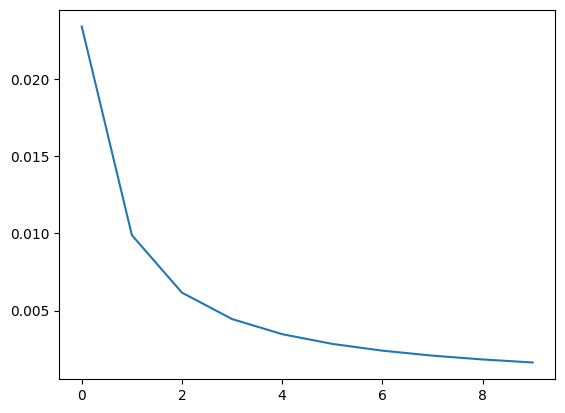

[1.]


In [ ]:
# Example 1: XOR

# Cheat and start at local minimum
net = NeuralNetwork(
    2,2,1,
    W1 = np.array([[1., 0.], [0., 1.]]),
    W2 = np.array([[0.1, 0.2]]).T
)

XOR_X = np.array([[0,0], [0,1], [1,0], [1,1]])
XOR_Y = np.array([[0,1,1,0]]).T

trainer = Trainer(
    x_train = XOR_X,
    y_train = XOR_Y,
    neural_network=net
)

trainer.train(learning_rate = 0.5, epochs = 10, iters=100000)
trainer.plot_cost_function()
print(trainer.test(XOR_X, XOR_Y))

100%|██████████| 1000/1000 [00:00<00:00, 10695.34it/s]


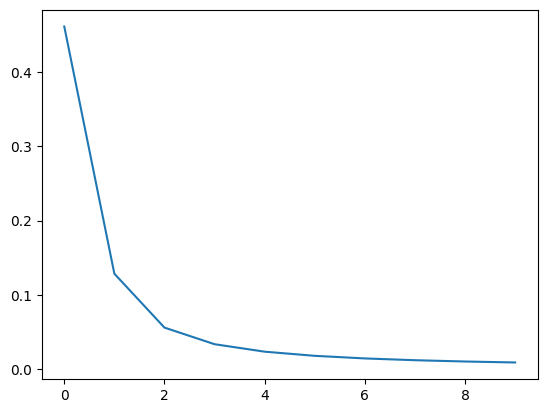

[1.]
(8, 1)


In [ ]:
# Example 2: Boolean function
# Here we test if a neural network can be trained on the 3 bit boolean function
# F(PQR) = 1 if PQR is prime, 0 otherwise

primes = {2,3,5,7}

from itertools import product

training_data = np.array( [[p,q,r,int(4*p+2*q+r in primes)] for p,q,r in product((0,1), repeat=3)] )
X_train = training_data[:, :3]
Y_train = training_data[:, 3:]

net = NeuralNetwork(3,4,1)

trainer2 = Trainer(
    x_train = X_train,
    y_train = Y_train,
    neural_network=net
)

trainer2.train(learning_rate = 0.05, epochs=10, iters=10000)
trainer2.plot_cost_function()
print(trainer2.test(X_train, Y_train))
print(Y_train.shape)

100%|██████████| 500/500 [01:24<00:00,  5.93it/s]


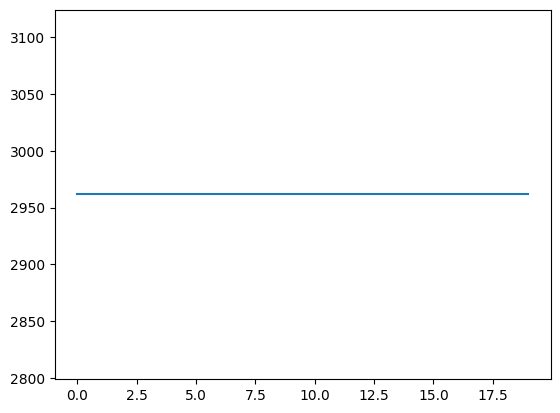

array([0.902])

In [ ]:
# Example 3: MNIST classifier
# We classify whether or not a digit is a zero or not

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((x_train.shape[0], 784)) / 256
x_test = x_test.reshape((x_test.shape[0], 784)) / 256
y_train = np.array( [(y_train == 0)] ).transpose()
y_test = np.array( [(y_test == 0)] ).transpose()


net = NeuralNetwork(784, 50, 1)
trainer3 = Trainer(
    x_train = x_train,
    y_train = y_train,
    neural_network=net
)

trainer3.train(learning_rate = 0.025, epochs=20, iters=10000, batch_size = 10000)
trainer3.plot_cost_function()
trainer3.test(x_test,y_test)